In [1]:
import torch
from math import pi,sqrt,log,e,exp
from time import time
from matplotlib import pyplot
import numpy as np
from matplotlib import pyplot as plt
from tqdm.autonotebook import tqdm
#torch.set_default_dtype(torch.float64)
device = torch.device("cuda:7")

In [2]:
from src.models.flows.coupling_cells.real_nvp import RealNVP
from src.models.flows.sampling import FactorizedGaussianSampler, UniformSampler
from src.models.flows.analytic_flows.element_wise import InvertibleAnalyticSigmoid
from src.models.flows.sequential import InvertibleSequentialFlow
from src.training.weighted_dataset.dkl_training import BasicStatefulDKLTrainer
from src import setup_std_stream_rootlogger
from src.integration.flat_refine_integrator import FlatSurveySamplingIntegrator

In [3]:
setup_std_stream_rootlogger(debug=False)

In [4]:
def f(x):
    return torch.exp(-10*(2*x[:,1]-torch.cos(4*pi*x[:,0])-1)**2)

In [5]:
posterior=UniformSampler(d=2,low=0.,high=1.,device=device)
prior=FactorizedGaussianSampler(d=2,device=device)

In [6]:
try:
    del model
except:
    pass


model  = InvertibleSequentialFlow(2,[
        RealNVP(d=2,
              mask=[True,False],
              d_hidden=256,
              n_hidden=16,).to(device),
        RealNVP(d=2,
              mask=[False,True],
              d_hidden=256,
              n_hidden=16,).to(device),
        RealNVP(d=2,
              mask=[True,False],
              d_hidden=256,
              n_hidden=16,).to(device),
        RealNVP(d=2,
              mask=[False,True],
              d_hidden=256,
              n_hidden=16,).to(device), 
    InvertibleAnalyticSigmoid(d=2),
])

optim = torch.optim.Adam(model.parameters(),lr=1.e-4)

In [7]:
trainer = BasicStatefulDKLTrainer(flow=model,latent_prior=prior)

In [8]:
trainer.set_config(n_epochs=100, minibatch_size=20000, optim=torch.optim.Adam(model.parameters()))

In [9]:
integrator=FlatSurveySamplingIntegrator(f,trainer,2,device=device)

In [10]:
result=integrator.integrate(1,10)

Starting integration
Initializing the survey phase
Starting the survey phase
Training on batch: 100000 points
Epoch 1/100
Epoch 2/100
Epoch 3/100
Epoch 4/100
Epoch 5/100
Epoch 6/100
Epoch 7/100
Epoch 8/100
Epoch 9/100
Epoch 10/100
Epoch 11/100
Epoch 12/100
Epoch 13/100
Epoch 14/100
Epoch 15/100
Epoch 16/100
Epoch 17/100
Epoch 18/100
Epoch 19/100
Epoch 20/100
Epoch 21/100
Epoch 22/100
Epoch 23/100
Epoch 24/100
Epoch 25/100
Epoch 26/100
Epoch 27/100
Epoch 28/100
Epoch 29/100
Epoch 30/100
Epoch 31/100
Epoch 32/100
Epoch 33/100
Epoch 34/100
Epoch 35/100
Epoch 36/100
Epoch 37/100
Epoch 38/100
Epoch 39/100
Epoch 40/100
Epoch 41/100
Epoch 42/100
Epoch 43/100
Epoch 44/100
Epoch 45/100
Epoch 46/100
Epoch 47/100
Epoch 48/100
Epoch 49/100
Epoch 50/100
Epoch 51/100
Epoch 52/100
Epoch 53/100
Epoch 54/100
Epoch 55/100
Epoch 56/100
Epoch 57/100
Epoch 58/100
Epoch 59/100
Epoch 60/100
Epoch 61/100
Epoch 62/100
Epoch 63/100
Epoch 64/100
Epoch 65/100
Epoch 66/100
Epoch 67/100
Epoch 68/100
Epoch 69/100
Ep

In [11]:
integrator.integration_history.loc[0]

integral                                  0.230462
error                                    0.0010754
n_points                                    100000
phase                                       survey
training record    [metrics, epochs, step, config]
Name: 0, dtype: object

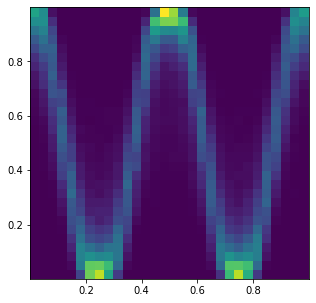

In [12]:
x=trainer.sample_forward(100000).cpu().numpy()
plt.figure(figsize=(5,5))
plt.hist2d(x[:,0],x[:,1],bins=30)
plt.show()

In [13]:
x,px,fx=integrator.sample_refine()

In [14]:
torch.mean(fx/px)

tensor(0.2301, device='cuda:7')

In [15]:
torch.var(fx/px)

tensor(0.0190, device='cuda:7')

In [16]:
x,px,fx=trainer.generate_target_batch_from_posterior(10000,f,posterior)

In [17]:
torch.mean(fx/px)

tensor(0.2279, device='cuda:7')

In [18]:
torch.var(fx/px)

tensor(0.1133, device='cuda:7')

In [28]:
result

(0.23006186187267302,
 0.0003193008445857474,
     integral     error  n_points   phase                  training record
 0   0.230462  0.001075    100000  survey  [metrics, epochs, step, config]
 1   0.230282  0.000735    100000  refine                              NaN
 2   0.229378  0.000323    100000  refine                              NaN
 3   0.229374  0.000379    100000  refine                              NaN
 4   0.230072  0.000688    100000  refine                              NaN
 5   0.230059  0.000451    100000  refine                              NaN
 6   0.229607  0.000363    100000  refine                              NaN
 7   0.229095  0.000411    100000  refine                              NaN
 8   0.229490  0.000357    100000  refine                              NaN
 9   0.232566  0.002606    100000  refine                              NaN
 10  0.230696  0.001229    100000  refine                              NaN)

In [27]:
((result[2][result[2]["phase"] == "refine"]["error"]**2).mean()/ len(result[2][result[2]["phase"] == "refine"]))**.5

0.0003193008445857474

In [30]:
((result[2][result[2]["phase"] == "refine"]["error"]**2).mean())**0.5

0.0010097179277064046

In [31]:
((result[2][result[2]["phase"] == "refine"]["error"]).mean())

0.0007542282139336561